Installing necessary libraries

In [1]:
pip install sgp4 matplotlib numpy pandas requests ffmpeg-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 6.1 MB/s eta 0:00:00


In [2]:
import requests
from sgp4.api import Satrec, jday
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter


In [3]:

#Load TLE data from the URL
url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"
response = requests.get(url)
tle_data = response.text.strip().split("\n")


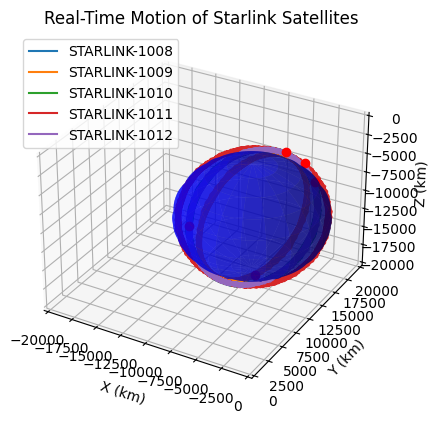

In [6]:
# Parse the TLE data for the first five Starlink satellites
sat_names = []
satellites = []

for i in range(5):  # For the first 5 satellites
    sat_name = tle_data[3 * i].strip()
    tle_lines = [tle_data[3 * i + 1].strip(), tle_data[3 * i + 2].strip()]
    satellite = Satrec.twoline2rv(tle_lines[0], tle_lines[1])

    sat_names.append(sat_name)
    satellites.append(satellite)

# Predicting satellite's position over time
def predict_orbital_path(satellite, start_time, end_time, step_minutes=10):
    positions = []
    times = []

    delta_t = end_time - start_time
    num_steps = int(delta_t.total_seconds() / (step_minutes * 60))

    for i in range(num_steps + 1):
        current_time = start_time + timedelta(minutes=step_minutes * i)

        # Convert current time to Julian date
        jd, fr = jday(current_time.year, current_time.month, current_time.day,
                      current_time.hour, current_time.minute, current_time.second)

        # Propagate the satellite orbit
        e, position, velocity = satellite.sgp4(jd, fr)

        if e == 0:  # If no errors, add position
            positions.append(position)  # X, Y, Z coordinates
            times.append(current_time)

    return times, np.array(positions)

# Time range for prediction (here,1 day)
start_time = datetime.utcnow()
end_time = start_time + timedelta(days=1)

# satellite positions for each satellite
sat_positions = []
sat_times = []

for sat in satellites:
    times, positions = predict_orbital_path(sat, start_time, end_time)
    sat_times.append(times)
    sat_positions.append(positions)

# orbital trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Earth as a sphere
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
x = 6371 * np.cos(u) * np.sin(v)
y = 6371 * np.sin(u) * np.sin(v)
z = 6371 * np.cos(v)
ax.plot_surface(x, y, z, color='b', alpha=0.6, rstride=5, cstride=5)

# Initialize lines for the trajectory of each satellite
lines = [ax.plot([], [], [], label=sat_name)[0] for sat_name in sat_names]
# Initialize points for each satellite
points = [ax.plot([], [], [], 'ro')[0] for _ in range(5)]


ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title('Real-Time Motion of Starlink Satellites')
plt.legend()

# Set axis limits(adjuststed in this way to crop the 3D plot and make satellites more visible)
ax.set_xlim([-20000, 0])
ax.set_ylim([0, 20000])
ax.set_zlim([-20000, 0])

# Animation update function
def update(num, sat_positions, lines, points):
    for i in range(5):  # Adjust to 5 satellites
        # Update the line (orbital path)
        lines[i].set_data(sat_positions[i][:num, 0], sat_positions[i][:num, 1])
        lines[i].set_3d_properties(sat_positions[i][:num, 2])

        # Update the point (real-time position)
        points[i].set_data([sat_positions[i][num, 0]], [sat_positions[i][num, 1]])  # Make these single-element lists
        points[i].set_3d_properties([sat_positions[i][num, 2]])

# Create the animation
ani = FuncAnimation(fig, update, frames=len(sat_positions[0]),
                    fargs=(sat_positions, lines, points), interval=100, repeat=True)


anim = ani

# Save the animation to MP4 video
anim.save('starlink_orbit_animation.mp4', writer='ffmpeg', fps=30)

plt.show()


In [7]:

#Save the results to a CSV file
for i, sat_name in enumerate(sat_names):
    df = pd.DataFrame({
        'Time': sat_times[i],
        'X (km)': sat_positions[i][:, 0],
        'Y (km)': sat_positions[i][:, 1],
        'Z (km)': sat_positions[i][:, 2]
    })
    csv_filename = f"{sat_name}_orbit.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Orbital data saved to {csv_filename}")


Orbital data saved to STARLINK-1008_orbit.csv
Orbital data saved to STARLINK-1009_orbit.csv
Orbital data saved to STARLINK-1010_orbit.csv
Orbital data saved to STARLINK-1011_orbit.csv
Orbital data saved to STARLINK-1012_orbit.csv


In [9]:
#I previously downloaded output files from google colab.
from google.colab import files

# Download the saved MP4 video file
files.download("starlink_orbit_animation.mp4")

from google.colab import files

# Assuming you have a CSV file named 'starlink_orbit_data.csv'
files.download('STARLINK-1008_orbit.csv')
files.download('STARLINK-1009_orbit.csv')
files.download('STARLINK-1010_orbit.csv')
files.download('STARLINK-1011_orbit.csv')
files.download('STARLINK-1012_orbit.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>